<a href="https://colab.research.google.com/github/agarr3/vajra-new-2/blob/main/AE_HYBRID_WESTERN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss(reduction="mean")
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1



DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/"
DATA_SONG_DIR = "originals"
DATA_IMG_DIR = "originals"
input_bins = 48
BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/"



seq_len=200
AE_encoded_dim = 64

class_level_loss_mode = "test"

print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
print(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "Western_numpy"))
             
train_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      train_files.append([file,file, "Western_numpy"])
    else:
      print(file)



for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", "Indian_numpy")):
  for file in fileList:
    if(True):
      train_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

train_data = pd.DataFrame(train_files, columns=['Images','songs','labels'])
train_data.head()

/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/originals/Western_numpy


,Images,songs,labels
0,western_147022_mel_1.npy,western_147022_mel_1.npy,Western_numpy
1,western_040182_mel_0.npy,western_040182_mel_0.npy,Western_numpy
2,western_133942_mel_0.npy,western_133942_mel_0.npy,Western_numpy
3,western_024912_mel_0.npy,western_024912_mel_0.npy,Western_numpy
4,western_130369_mel_1.npy,western_130369_mel_1.npy,Western_numpy


In [ ]:
test_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      test_files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
test_files = random.sample(test_files, len(test_files))

for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", "Indian_numpy")):
  for file in fileList:
    if(True):
      test_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

test_data = pd.DataFrame(test_files, columns=['Images','songs','labels'])
test_data.head()

,Images,songs,labels
0,western_130993_mel_0.npy,western_130993_mel_0.npy,Western_numpy
1,western_120189_mel_1.npy,western_120189_mel_1.npy,Western_numpy
2,western_111579_mel_1.npy,western_111579_mel_1.npy,Western_numpy
3,western_111793_mel_1.npy,western_111793_mel_1.npy,Western_numpy
4,western_122503_mel_1.npy,western_122503_mel_1.npy,Western_numpy


In [ ]:
train_data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,2811,2811
Western_numpy,2800,2800


In [ ]:
test_data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,1205,1205
Western_numpy,1200,1200


/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/originals/test/Western_numpy/western_142570_mel_1.npy
75.294266


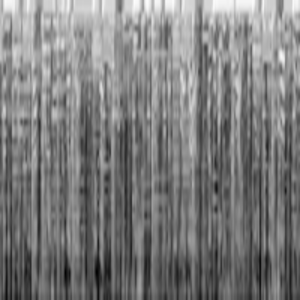

In [ ]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", test_data.loc[test_idx, 'labels'], test_data.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



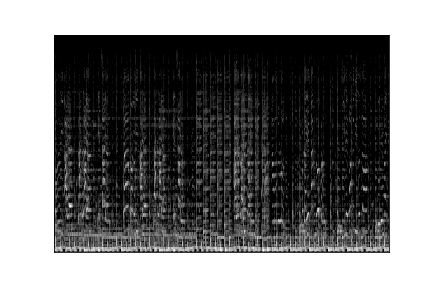

In [ ]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [ ]:
lb = LabelEncoder()
train_data['encoded_labels'] = lb.fit_transform(train_data['labels'])
train_data.head()

,Images,songs,labels,encoded_labels
0,western_147022_mel_1.npy,western_147022_mel_1.npy,Western_numpy,1
1,western_040182_mel_0.npy,western_040182_mel_0.npy,Western_numpy,1
2,western_133942_mel_0.npy,western_133942_mel_0.npy,Western_numpy,1
3,western_024912_mel_0.npy,western_024912_mel_0.npy,Western_numpy,1
4,western_130369_mel_1.npy,western_130369_mel_1.npy,Western_numpy,1


In [ ]:
test_data['encoded_labels'] = lb.transform(test_data['labels'])
test_data.head()

,Images,songs,labels,encoded_labels
0,western_130993_mel_0.npy,western_130993_mel_0.npy,Western_numpy,1
1,western_120189_mel_1.npy,western_120189_mel_1.npy,Western_numpy,1
2,western_111579_mel_1.npy,western_111579_mel_1.npy,Western_numpy,1
3,western_111793_mel_1.npy,western_111793_mel_1.npy,Western_numpy,1
4,western_122503_mel_1.npy,western_122503_mel_1.npy,Western_numpy,1


In [ ]:
classes = ('Indian_numpy', 'Western_numpy')
train_data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2811,2811
Western_numpy,1,2800,2800


In [ ]:
test_data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205
Western_numpy,1,1200,1200


In [ ]:
from sklearn.model_selection import train_test_split

train_data_combined = train_data.copy(deep=True)
test_data_combined = test_data.copy(deep=True)

train_data = train_data[train_data['labels'] == "Western_numpy"]
test_data = test_data[test_data['labels'] == "Western_numpy"]


#df_train, df_test = train_test_split(data, test_size=validation_split, stratify=data[["labels"]])

df_train = train_data.reset_index(drop=True)
df_test = test_data.reset_index(drop=True)


In [ ]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Western_numpy,1,2800,2800


In [ ]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Western_numpy,1,1200,1200


In [ ]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [ ]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        fileName = self.img_data.loc[index, 'Images']
        return data, label, fileName



In [ ]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training"),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test"),transform)

train_dataset_combined = MEL_Dataset(train_data_combined,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training"),transform)
test_dataset_combined = MEL_Dataset(test_data_combined,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test"),transform)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

trainloader_combined = torch.utils.data.DataLoader(train_dataset_combined, batch_size=batch_size)
testloader_combined = torch.utils.data.DataLoader(test_dataset_combined, batch_size=batch_size)

In [ ]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

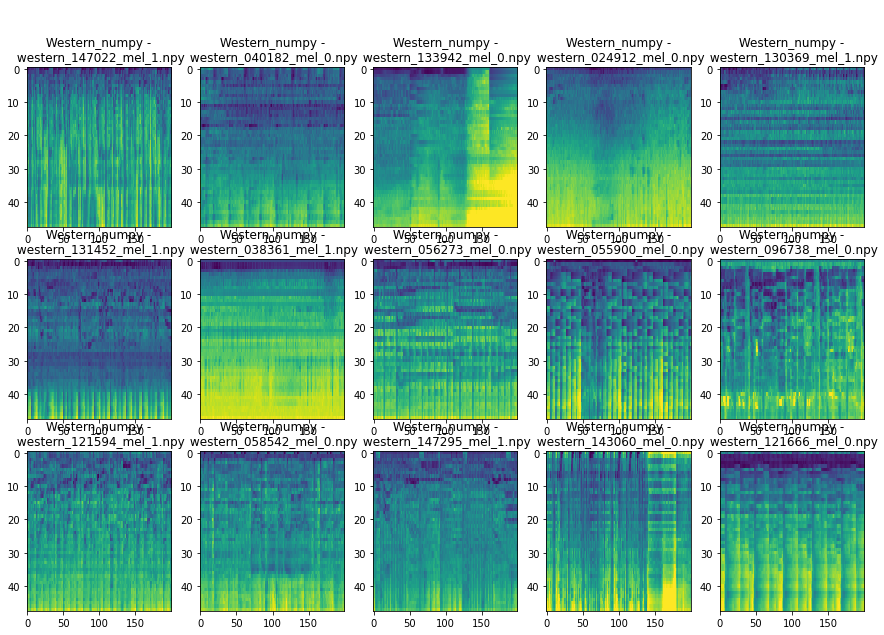

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, fileName = images[i], labels[i], fileNames[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"\n \n {arthopod_types[label.item()]} - \n {fileName}") # add label

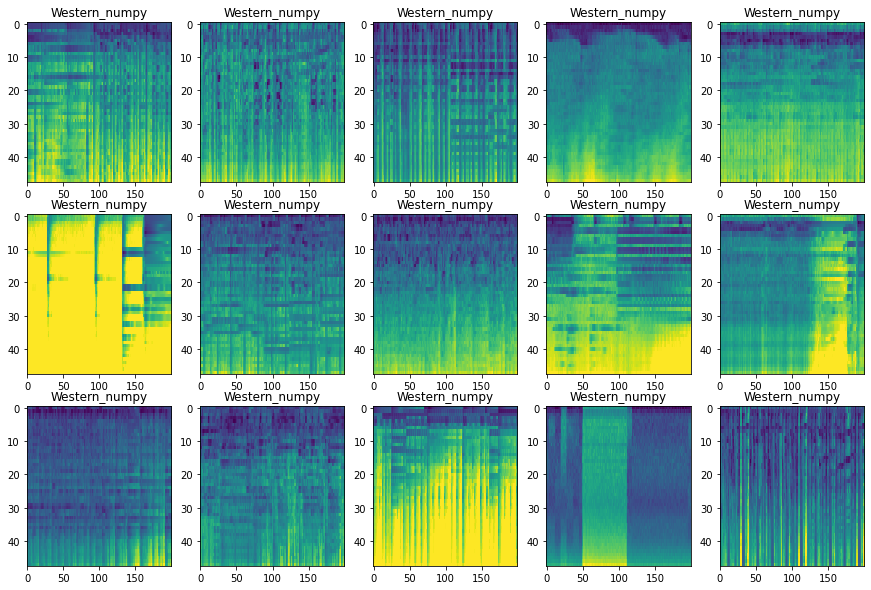

In [ ]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


def visualize_class_loss(in_loss_graph, we_loss_graph):
  x = range(len(in_loss_graph))
      
  # plot lines
  plt.plot(x, in_loss_graph, label = "Indian Loss")
  plt.plot(x, we_loss_graph, label = "Western Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1452.823
[1,     2] loss: 1561.600
[1,     3] loss: 1466.249
[1,     4] loss: 1258.479
[1,     5] loss: 1324.506
[1,     6] loss: 1094.280
[1,     7] loss: 749.194
[1,     8] loss: 601.676
[1,     9] loss: 239.397
[1,    10] loss: 718.211
[1,    11] loss: 441.479
[1,    12] loss: 186.754
[1,    13] loss: 171.861
[1,    14] loss: 167.754
[1,    15] loss: 255.773
[1,    16] loss: 193.453
[1,    17] loss: 281.555
[1,    18] loss: 277.682
[1,    19] loss: 224.310
[1,    20] loss: 142.567
[1,    21] loss: 216.947
[1,    22] loss: 192.889
[1,    23] loss: 141.365
[1,    24] loss: 167.736
[1,    25] loss: 193.178
[1,    26] loss: 178.800
[1,    27] loss: 185.276
[1,    28] loss: 191.141
[1,    29] loss: 167.215
[1,    30] loss: 128.014
[1,    31] loss: 161.055
[1,    32] loss: 143.986
[1,    33] loss: 144.933
[1,    34] loss: 142.804
[1,    35] loss: 124.608
[1,    36] loss: 170.625
[1,    37] loss: 146.834
[1,    38] loss: 156.406
[1,    39] loss: 140.541
[1,    40] loss: 12

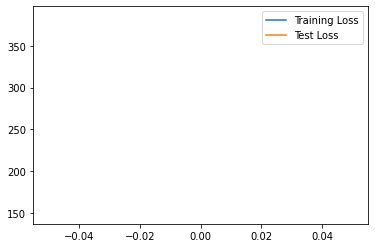

[2,     1] loss: 127.287
[2,     2] loss: 156.040
[2,     3] loss: 135.832
[2,     4] loss: 127.785
[2,     5] loss: 156.205
[2,     6] loss: 141.720
[2,     7] loss: 123.224
[2,     8] loss: 166.245
[2,     9] loss: 137.289
[2,    10] loss: 145.782
[2,    11] loss: 133.705
[2,    12] loss: 137.925
[2,    13] loss: 136.481
[2,    14] loss: 117.871
[2,    15] loss: 138.810
[2,    16] loss: 114.563
[2,    17] loss: 123.841
[2,    18] loss: 137.264
[2,    19] loss: 122.986
[2,    20] loss: 102.913
[2,    21] loss: 147.474
[2,    22] loss: 143.413
[2,    23] loss: 103.252
[2,    24] loss: 110.783
[2,    25] loss: 113.424
[2,    26] loss: 109.648
[2,    27] loss: 121.285
[2,    28] loss: 119.380
[2,    29] loss: 119.202
[2,    30] loss: 100.388
[2,    31] loss: 115.325
[2,    32] loss: 98.899
[2,    33] loss: 96.666
[2,    34] loss: 89.773
[2,    35] loss: 81.895
[2,    36] loss: 102.795
[2,    37] loss: 86.448
[2,    38] loss: 99.306
[2,    39] loss: 87.998
[2,    40] loss: 74.573
[2,    4

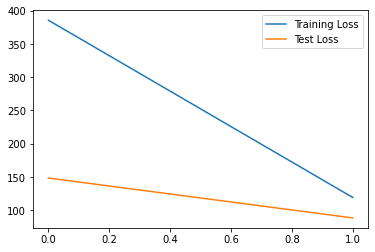

[3,     1] loss: 78.787
[3,     2] loss: 97.312
[3,     3] loss: 74.758
[3,     4] loss: 77.237
[3,     5] loss: 83.002
[3,     6] loss: 76.790
[3,     7] loss: 74.282
[3,     8] loss: 94.888
[3,     9] loss: 83.630
[3,    10] loss: 85.545
[3,    11] loss: 75.120
[3,    12] loss: 88.310
[3,    13] loss: 80.328
[3,    14] loss: 79.975
[3,    15] loss: 82.133
[3,    16] loss: 73.129
[3,    17] loss: 77.985
[3,    18] loss: 76.123
[3,    19] loss: 75.653
[3,    20] loss: 72.753
[3,    21] loss: 80.258
[3,    22] loss: 94.730
[3,    23] loss: 69.368
[3,    24] loss: 74.134
[3,    25] loss: 75.997
[3,    26] loss: 73.919
[3,    27] loss: 88.699
[3,    28] loss: 83.648
[3,    29] loss: 82.683
[3,    30] loss: 81.633
[3,    31] loss: 79.085
[3,    32] loss: 74.654
[3,    33] loss: 75.221
[3,    34] loss: 73.253
[3,    35] loss: 72.112
[3,    36] loss: 83.411
[3,    37] loss: 78.395
[3,    38] loss: 90.437
[3,    39] loss: 81.739
[3,    40] loss: 68.461
[3,    41] loss: 73.771
[3,    42] loss:

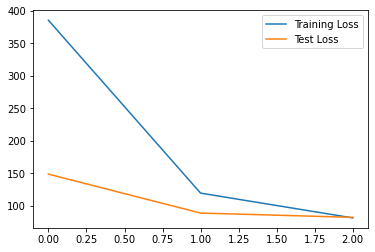

[4,     1] loss: 71.923
[4,     2] loss: 91.814
[4,     3] loss: 70.580
[4,     4] loss: 73.383
[4,     5] loss: 80.442
[4,     6] loss: 75.142
[4,     7] loss: 72.044
[4,     8] loss: 92.819
[4,     9] loss: 81.764
[4,    10] loss: 83.670
[4,    11] loss: 73.020
[4,    12] loss: 86.297
[4,    13] loss: 78.848
[4,    14] loss: 79.376
[4,    15] loss: 80.853
[4,    16] loss: 72.580
[4,    17] loss: 77.835
[4,    18] loss: 75.506
[4,    19] loss: 76.065
[4,    20] loss: 72.087
[4,    21] loss: 80.816
[4,    22] loss: 93.547
[4,    23] loss: 69.934
[4,    24] loss: 73.155
[4,    25] loss: 76.596
[4,    26] loss: 73.072
[4,    27] loss: 88.868
[4,    28] loss: 82.726
[4,    29] loss: 82.490
[4,    30] loss: 80.903
[4,    31] loss: 78.486
[4,    32] loss: 73.952
[4,    33] loss: 74.297
[4,    34] loss: 72.978
[4,    35] loss: 71.310
[4,    36] loss: 82.726
[4,    37] loss: 77.593
[4,    38] loss: 89.407
[4,    39] loss: 81.149
[4,    40] loss: 67.859
[4,    41] loss: 73.121
[4,    42] loss:

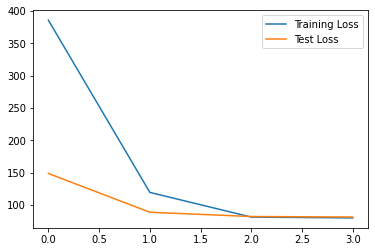

[5,     1] loss: 71.039
[5,     2] loss: 90.782
[5,     3] loss: 69.752
[5,     4] loss: 72.479
[5,     5] loss: 79.278
[5,     6] loss: 74.207
[5,     7] loss: 71.199
[5,     8] loss: 91.504
[5,     9] loss: 81.267
[5,    10] loss: 82.076
[5,    11] loss: 72.464
[5,    12] loss: 85.011
[5,    13] loss: 79.040
[5,    14] loss: 78.102
[5,    15] loss: 80.601
[5,    16] loss: 71.296
[5,    17] loss: 77.639
[5,    18] loss: 73.994
[5,    19] loss: 75.459
[5,    20] loss: 70.900
[5,    21] loss: 78.700
[5,    22] loss: 93.026
[5,    23] loss: 68.578
[5,    24] loss: 73.475
[5,    25] loss: 74.958
[5,    26] loss: 73.683
[5,    27] loss: 86.503
[5,    28] loss: 82.454
[5,    29] loss: 80.448
[5,    30] loss: 80.604
[5,    31] loss: 77.178
[5,    32] loss: 73.453
[5,    33] loss: 74.187
[5,    34] loss: 72.015
[5,    35] loss: 71.198
[5,    36] loss: 81.308
[5,    37] loss: 77.429
[5,    38] loss: 87.910
[5,    39] loss: 80.978
[5,    40] loss: 66.665
[5,    41] loss: 72.549
[5,    42] loss:

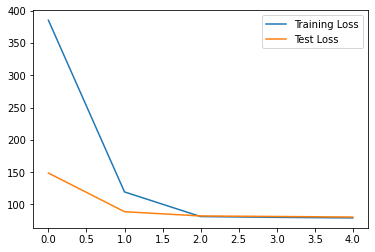

[6,     1] loss: 70.147
[6,     2] loss: 89.979
[6,     3] loss: 68.843
[6,     4] loss: 71.575
[6,     5] loss: 78.708
[6,     6] loss: 73.502
[6,     7] loss: 70.716
[6,     8] loss: 90.345
[6,     9] loss: 81.012
[6,    10] loss: 80.959
[6,    11] loss: 71.909
[6,    12] loss: 83.814
[6,    13] loss: 78.956
[6,    14] loss: 77.287
[6,    15] loss: 79.905
[6,    16] loss: 70.768
[6,    17] loss: 76.508
[6,    18] loss: 73.398
[6,    19] loss: 74.104
[6,    20] loss: 70.279
[6,    21] loss: 76.460
[6,    22] loss: 92.634
[6,    23] loss: 67.423
[6,    24] loss: 72.606
[6,    25] loss: 74.076
[6,    26] loss: 72.758
[6,    27] loss: 85.288
[6,    28] loss: 80.868
[6,    29] loss: 79.591
[6,    30] loss: 79.329
[6,    31] loss: 76.618
[6,    32] loss: 72.742
[6,    33] loss: 73.565
[6,    34] loss: 70.951
[6,    35] loss: 70.380
[6,    36] loss: 80.327
[6,    37] loss: 76.469
[6,    38] loss: 86.702
[6,    39] loss: 79.757
[6,    40] loss: 66.074
[6,    41] loss: 71.732
[6,    42] loss:

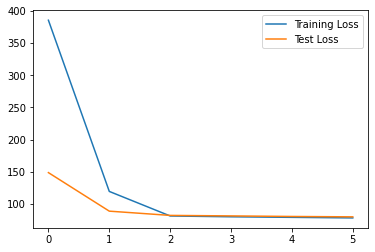

[7,     1] loss: 69.438
[7,     2] loss: 88.404
[7,     3] loss: 68.295
[7,     4] loss: 70.508
[7,     5] loss: 78.411
[7,     6] loss: 72.579
[7,     7] loss: 70.147
[7,     8] loss: 88.909
[7,     9] loss: 80.303
[7,    10] loss: 79.914
[7,    11] loss: 70.934
[7,    12] loss: 82.943
[7,    13] loss: 77.852
[7,    14] loss: 76.569
[7,    15] loss: 78.478
[7,    16] loss: 70.375
[7,    17] loss: 74.690
[7,    18] loss: 72.733
[7,    19] loss: 72.554
[7,    20] loss: 69.452
[7,    21] loss: 74.972
[7,    22] loss: 91.197
[7,    23] loss: 66.637
[7,    24] loss: 70.725
[7,    25] loss: 73.475
[7,    26] loss: 71.271
[7,    27] loss: 83.985
[7,    28] loss: 79.356
[7,    29] loss: 78.447
[7,    30] loss: 78.146
[7,    31] loss: 75.437
[7,    32] loss: 72.145
[7,    33] loss: 71.986
[7,    34] loss: 70.175
[7,    35] loss: 69.154
[7,    36] loss: 78.916
[7,    37] loss: 75.224
[7,    38] loss: 84.722
[7,    39] loss: 78.411
[7,    40] loss: 65.119
[7,    41] loss: 70.766
[7,    42] loss:

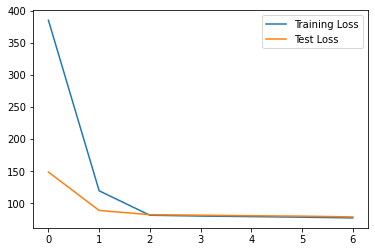

[8,     1] loss: 68.133
[8,     2] loss: 86.527
[8,     3] loss: 67.191
[8,     4] loss: 69.409
[8,     5] loss: 77.057
[8,     6] loss: 71.586
[8,     7] loss: 68.823
[8,     8] loss: 86.851
[8,     9] loss: 78.713
[8,    10] loss: 78.764
[8,    11] loss: 69.579
[8,    12] loss: 81.272
[8,    13] loss: 76.759
[8,    14] loss: 75.017
[8,    15] loss: 77.615
[8,    16] loss: 68.906
[8,    17] loss: 73.964
[8,    18] loss: 70.993
[8,    19] loss: 71.672
[8,    20] loss: 68.050
[8,    21] loss: 73.823
[8,    22] loss: 89.118
[8,    23] loss: 66.113
[8,    24] loss: 69.415
[8,    25] loss: 72.557
[8,    26] loss: 70.453
[8,    27] loss: 82.041
[8,    28] loss: 78.094
[8,    29] loss: 76.852
[8,    30] loss: 76.643
[8,    31] loss: 73.698
[8,    32] loss: 70.708
[8,    33] loss: 70.064
[8,    34] loss: 69.083
[8,    35] loss: 67.876
[8,    36] loss: 76.557
[8,    37] loss: 73.839
[8,    38] loss: 81.574
[8,    39] loss: 76.428
[8,    40] loss: 63.623
[8,    41] loss: 68.854
[8,    42] loss:

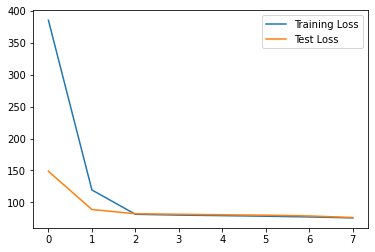

[9,     1] loss: 65.847
[9,     2] loss: 83.477
[9,     3] loss: 65.090
[9,     4] loss: 67.668
[9,     5] loss: 73.756
[9,     6] loss: 69.508
[9,     7] loss: 66.002
[9,     8] loss: 83.458
[9,     9] loss: 75.320
[9,    10] loss: 77.250
[9,    11] loss: 66.191
[9,    12] loss: 79.000
[9,    13] loss: 72.900
[9,    14] loss: 73.088
[9,    15] loss: 74.210
[9,    16] loss: 66.696
[9,    17] loss: 70.811
[9,    18] loss: 69.581
[9,    19] loss: 68.034
[9,    20] loss: 64.151
[9,    21] loss: 71.551
[9,    22] loss: 84.221
[9,    23] loss: 63.241
[9,    24] loss: 65.742
[9,    25] loss: 69.711
[9,    26] loss: 65.701
[9,    27] loss: 78.085
[9,    28] loss: 73.891
[9,    29] loss: 73.180
[9,    30] loss: 73.735
[9,    31] loss: 69.922
[9,    32] loss: 69.861
[9,    33] loss: 65.035
[9,    34] loss: 67.498
[9,    35] loss: 63.780
[9,    36] loss: 71.585
[9,    37] loss: 69.005
[9,    38] loss: 75.419
[9,    39] loss: 69.142
[9,    40] loss: 60.603
[9,    41] loss: 63.971
[9,    42] loss:

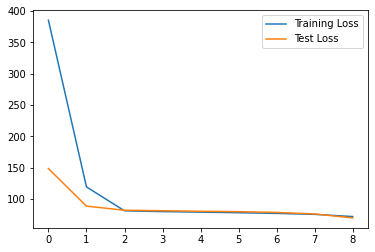

[10,     1] loss: 61.291
[10,     2] loss: 76.104
[10,     3] loss: 59.429
[10,     4] loss: 63.642
[10,     5] loss: 66.331
[10,     6] loss: 63.750
[10,     7] loss: 60.453
[10,     8] loss: 74.391
[10,     9] loss: 69.750
[10,    10] loss: 73.173
[10,    11] loss: 59.385
[10,    12] loss: 74.106
[10,    13] loss: 65.552
[10,    14] loss: 66.816
[10,    15] loss: 69.538
[10,    16] loss: 62.236
[10,    17] loss: 64.628
[10,    18] loss: 64.127
[10,    19] loss: 61.537
[10,    20] loss: 55.117
[10,    21] loss: 65.229
[10,    22] loss: 77.062
[10,    23] loss: 57.324
[10,    24] loss: 61.413
[10,    25] loss: 63.278
[10,    26] loss: 58.466
[10,    27] loss: 72.217
[10,    28] loss: 66.836
[10,    29] loss: 67.889
[10,    30] loss: 66.849
[10,    31] loss: 65.065
[10,    32] loss: 63.612
[10,    33] loss: 60.126
[10,    34] loss: 62.721
[10,    35] loss: 59.448
[10,    36] loss: 64.950
[10,    37] loss: 65.934
[10,    38] loss: 69.505
[10,    39] loss: 64.910
[10,    40] loss: 58.060


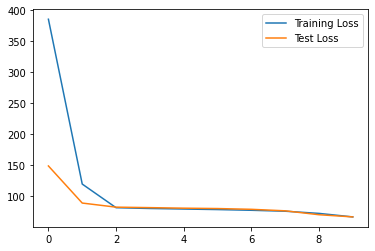

[11,     1] loss: 58.830
[11,     2] loss: 71.189
[11,     3] loss: 56.114
[11,     4] loss: 60.705
[11,     5] loss: 63.750
[11,     6] loss: 60.392
[11,     7] loss: 57.520
[11,     8] loss: 70.000
[11,     9] loss: 67.500
[11,    10] loss: 71.510
[11,    11] loss: 56.866
[11,    12] loss: 71.240
[11,    13] loss: 63.228
[11,    14] loss: 64.418
[11,    15] loss: 67.104
[11,    16] loss: 60.179
[11,    17] loss: 62.954
[11,    18] loss: 62.002
[11,    19] loss: 59.862
[11,    20] loss: 53.473
[11,    21] loss: 63.335
[11,    22] loss: 74.263
[11,    23] loss: 56.133
[11,    24] loss: 59.579
[11,    25] loss: 62.329
[11,    26] loss: 56.748
[11,    27] loss: 70.012
[11,    28] loss: 64.661
[11,    29] loss: 66.310
[11,    30] loss: 64.997
[11,    31] loss: 63.577
[11,    32] loss: 62.458
[11,    33] loss: 58.137
[11,    34] loss: 61.400
[11,    35] loss: 58.277
[11,    36] loss: 62.760
[11,    37] loss: 64.498
[11,    38] loss: 67.213
[11,    39] loss: 62.908
[11,    40] loss: 56.677


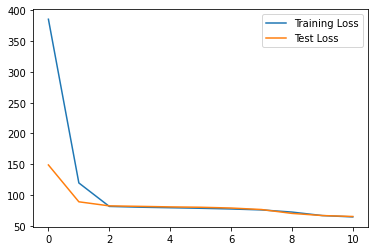

[12,     1] loss: 57.342
[12,     2] loss: 69.577
[12,     3] loss: 54.972
[12,     4] loss: 59.157
[12,     5] loss: 62.174
[12,     6] loss: 58.800
[12,     7] loss: 55.956
[12,     8] loss: 67.649
[12,     9] loss: 65.957
[12,    10] loss: 70.116
[12,    11] loss: 55.616
[12,    12] loss: 69.217
[12,    13] loss: 62.019
[12,    14] loss: 62.869
[12,    15] loss: 65.531
[12,    16] loss: 58.853
[12,    17] loss: 61.560
[12,    18] loss: 60.488
[12,    19] loss: 58.945
[12,    20] loss: 52.216
[12,    21] loss: 62.162
[12,    22] loss: 71.911
[12,    23] loss: 55.022
[12,    24] loss: 57.891
[12,    25] loss: 61.319
[12,    26] loss: 55.330
[12,    27] loss: 68.135
[12,    28] loss: 63.034
[12,    29] loss: 64.684
[12,    30] loss: 63.423
[12,    31] loss: 62.080
[12,    32] loss: 60.834
[12,    33] loss: 56.797
[12,    34] loss: 60.147
[12,    35] loss: 57.234
[12,    36] loss: 60.908
[12,    37] loss: 63.399
[12,    38] loss: 64.569
[12,    39] loss: 61.425
[12,    40] loss: 55.407


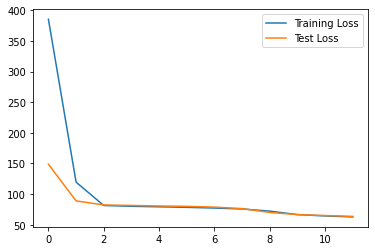

[13,     1] loss: 55.929
[13,     2] loss: 67.562
[13,     3] loss: 54.036
[13,     4] loss: 57.846
[13,     5] loss: 60.793
[13,     6] loss: 57.407
[13,     7] loss: 54.693
[13,     8] loss: 65.336
[13,     9] loss: 64.456
[13,    10] loss: 68.875
[13,    11] loss: 54.770
[13,    12] loss: 67.459
[13,    13] loss: 60.709
[13,    14] loss: 61.746
[13,    15] loss: 63.854
[13,    16] loss: 57.553
[13,    17] loss: 60.166
[13,    18] loss: 59.121
[13,    19] loss: 57.997
[13,    20] loss: 51.083
[13,    21] loss: 60.966
[13,    22] loss: 69.561
[13,    23] loss: 53.736
[13,    24] loss: 56.411
[13,    25] loss: 59.934
[13,    26] loss: 54.143
[13,    27] loss: 66.456
[13,    28] loss: 61.209
[13,    29] loss: 63.303
[13,    30] loss: 61.900
[13,    31] loss: 60.396
[13,    32] loss: 59.229
[13,    33] loss: 55.655
[13,    34] loss: 58.685
[13,    35] loss: 56.360
[13,    36] loss: 58.499
[13,    37] loss: 62.304
[13,    38] loss: 62.123
[13,    39] loss: 60.154
[13,    40] loss: 54.206


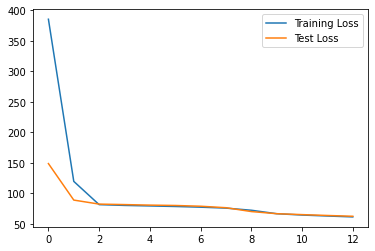

[14,     1] loss: 54.675
[14,     2] loss: 66.133
[14,     3] loss: 53.298
[14,     4] loss: 56.631
[14,     5] loss: 59.406
[14,     6] loss: 56.144
[14,     7] loss: 53.641
[14,     8] loss: 63.048
[14,     9] loss: 62.930
[14,    10] loss: 67.489
[14,    11] loss: 53.920
[14,    12] loss: 65.654
[14,    13] loss: 58.834
[14,    14] loss: 60.441
[14,    15] loss: 62.103
[14,    16] loss: 56.125
[14,    17] loss: 58.463
[14,    18] loss: 57.680
[14,    19] loss: 56.938
[14,    20] loss: 49.657
[14,    21] loss: 59.534
[14,    22] loss: 66.994
[14,    23] loss: 52.401
[14,    24] loss: 54.714
[14,    25] loss: 58.144
[14,    26] loss: 52.806
[14,    27] loss: 64.768
[14,    28] loss: 59.136
[14,    29] loss: 61.662
[14,    30] loss: 60.499
[14,    31] loss: 59.021
[14,    32] loss: 57.365
[14,    33] loss: 54.695
[14,    34] loss: 57.143
[14,    35] loss: 55.136
[14,    36] loss: 56.156
[14,    37] loss: 60.127
[14,    38] loss: 59.445
[14,    39] loss: 57.793
[14,    40] loss: 52.784


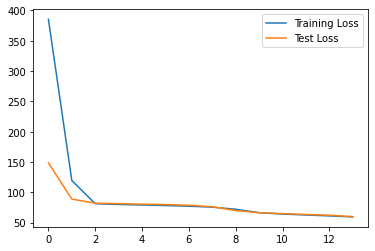

[15,     1] loss: 52.431
[15,     2] loss: 63.624
[15,     3] loss: 51.824
[15,     4] loss: 54.795
[15,     5] loss: 57.843
[15,     6] loss: 55.404
[15,     7] loss: 52.148
[15,     8] loss: 61.267
[15,     9] loss: 60.592
[15,    10] loss: 65.767
[15,    11] loss: 52.250
[15,    12] loss: 63.138
[15,    13] loss: 56.127
[15,    14] loss: 57.373
[15,    15] loss: 60.068
[15,    16] loss: 53.654
[15,    17] loss: 56.095
[15,    18] loss: 55.574
[15,    19] loss: 55.479
[15,    20] loss: 47.931
[15,    21] loss: 57.020
[15,    22] loss: 63.527
[15,    23] loss: 50.959
[15,    24] loss: 52.240
[15,    25] loss: 56.741
[15,    26] loss: 50.755
[15,    27] loss: 63.239
[15,    28] loss: 57.773
[15,    29] loss: 58.258
[15,    30] loss: 59.549
[15,    31] loss: 57.292
[15,    32] loss: 54.501
[15,    33] loss: 53.798
[15,    34] loss: 55.215
[15,    35] loss: 53.828
[15,    36] loss: 53.710
[15,    37] loss: 58.420
[15,    38] loss: 57.125
[15,    39] loss: 56.548
[15,    40] loss: 51.390


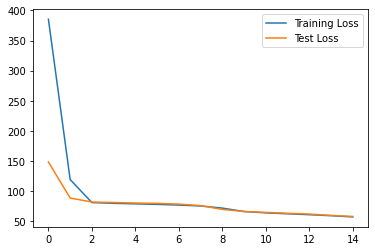

[16,     1] loss: 50.997
[16,     2] loss: 61.051
[16,     3] loss: 50.939
[16,     4] loss: 52.859
[16,     5] loss: 55.640
[16,     6] loss: 54.691
[16,     7] loss: 50.365
[16,     8] loss: 59.428
[16,     9] loss: 58.990
[16,    10] loss: 63.135
[16,    11] loss: 51.856
[16,    12] loss: 60.344
[16,    13] loss: 54.435
[16,    14] loss: 54.428
[16,    15] loss: 58.209
[16,    16] loss: 52.461
[16,    17] loss: 53.736
[16,    18] loss: 53.919
[16,    19] loss: 54.173
[16,    20] loss: 46.746
[16,    21] loss: 54.770
[16,    22] loss: 62.107
[16,    23] loss: 48.848
[16,    24] loss: 51.338
[16,    25] loss: 55.296
[16,    26] loss: 49.349
[16,    27] loss: 62.842
[16,    28] loss: 55.128
[16,    29] loss: 58.081
[16,    30] loss: 57.862
[16,    31] loss: 56.041
[16,    32] loss: 54.986
[16,    33] loss: 51.251
[16,    34] loss: 55.393
[16,    35] loss: 52.298
[16,    36] loss: 52.328
[16,    37] loss: 57.293
[16,    38] loss: 56.605
[16,    39] loss: 55.817
[16,    40] loss: 50.425


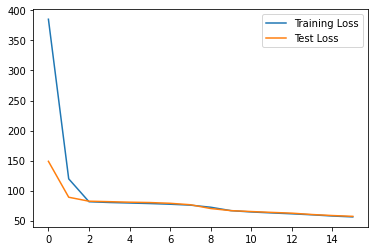

[17,     1] loss: 49.892
[17,     2] loss: 58.911
[17,     3] loss: 49.749
[17,     4] loss: 51.767
[17,     5] loss: 53.063
[17,     6] loss: 50.576
[17,     7] loss: 49.347
[17,     8] loss: 56.473
[17,     9] loss: 55.792
[17,    10] loss: 61.583
[17,    11] loss: 49.197
[17,    12] loss: 58.708
[17,    13] loss: 53.048
[17,    14] loss: 53.021
[17,    15] loss: 55.757
[17,    16] loss: 49.893
[17,    17] loss: 51.883
[17,    18] loss: 51.582
[17,    19] loss: 52.403
[17,    20] loss: 45.291
[17,    21] loss: 52.951
[17,    22] loss: 58.692
[17,    23] loss: 46.744
[17,    24] loss: 48.862
[17,    25] loss: 52.164
[17,    26] loss: 47.434
[17,    27] loss: 58.794
[17,    28] loss: 53.072
[17,    29] loss: 54.506
[17,    30] loss: 53.372
[17,    31] loss: 53.259
[17,    32] loss: 49.747
[17,    33] loss: 49.664
[17,    34] loss: 51.604
[17,    35] loss: 49.826
[17,    36] loss: 48.658
[17,    37] loss: 53.957
[17,    38] loss: 53.824
[17,    39] loss: 52.188
[17,    40] loss: 48.565


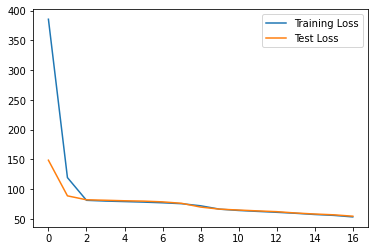

[18,     1] loss: 47.772
[18,     2] loss: 56.355
[18,     3] loss: 47.219
[18,     4] loss: 50.371
[18,     5] loss: 49.621
[18,     6] loss: 49.370
[18,     7] loss: 46.761
[18,     8] loss: 53.619
[18,     9] loss: 53.693
[18,    10] loss: 58.425
[18,    11] loss: 47.286
[18,    12] loss: 56.567
[18,    13] loss: 51.379
[18,    14] loss: 51.436
[18,    15] loss: 54.185
[18,    16] loss: 48.269
[18,    17] loss: 50.099
[18,    18] loss: 50.155
[18,    19] loss: 50.997
[18,    20] loss: 44.341
[18,    21] loss: 51.901
[18,    22] loss: 57.422
[18,    23] loss: 45.359
[18,    24] loss: 47.387
[18,    25] loss: 50.559
[18,    26] loss: 46.620
[18,    27] loss: 57.149
[18,    28] loss: 51.381
[18,    29] loss: 53.491
[18,    30] loss: 52.591
[18,    31] loss: 51.950
[18,    32] loss: 49.190
[18,    33] loss: 48.501
[18,    34] loss: 50.807
[18,    35] loss: 48.638
[18,    36] loss: 47.301
[18,    37] loss: 52.532
[18,    38] loss: 52.328
[18,    39] loss: 50.304
[18,    40] loss: 47.477


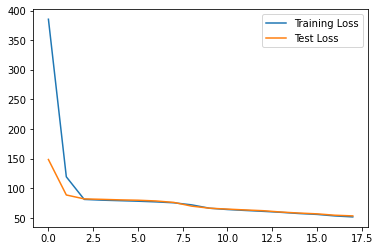

[19,     1] loss: 46.635
[19,     2] loss: 54.579
[19,     3] loss: 45.866
[19,     4] loss: 48.794
[19,     5] loss: 48.354
[19,     6] loss: 47.862
[19,     7] loss: 45.521
[19,     8] loss: 51.932
[19,     9] loss: 52.083
[19,    10] loss: 56.470
[19,    11] loss: 45.971
[19,    12] loss: 54.956
[19,    13] loss: 49.439
[19,    14] loss: 50.146
[19,    15] loss: 52.636
[19,    16] loss: 46.981
[19,    17] loss: 48.920
[19,    18] loss: 48.206
[19,    19] loss: 49.678
[19,    20] loss: 43.387
[19,    21] loss: 50.563
[19,    22] loss: 56.321
[19,    23] loss: 44.176
[19,    24] loss: 45.768
[19,    25] loss: 49.599
[19,    26] loss: 45.462
[19,    27] loss: 55.461
[19,    28] loss: 50.364
[19,    29] loss: 51.937
[19,    30] loss: 51.007
[19,    31] loss: 50.621
[19,    32] loss: 47.729
[19,    33] loss: 47.676
[19,    34] loss: 49.091
[19,    35] loss: 47.213
[19,    36] loss: 46.191
[19,    37] loss: 51.001
[19,    38] loss: 50.859
[19,    39] loss: 49.186
[19,    40] loss: 46.474


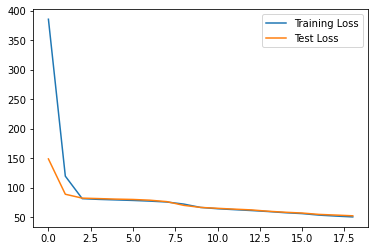

[20,     1] loss: 45.512
[20,     2] loss: 53.071
[20,     3] loss: 45.054
[20,     4] loss: 47.429
[20,     5] loss: 47.879
[20,     6] loss: 46.992
[20,     7] loss: 44.669
[20,     8] loss: 50.731
[20,     9] loss: 50.498
[20,    10] loss: 55.220
[20,    11] loss: 44.733
[20,    12] loss: 53.514
[20,    13] loss: 48.344
[20,    14] loss: 48.725
[20,    15] loss: 50.888
[20,    16] loss: 45.974
[20,    17] loss: 47.784
[20,    18] loss: 47.296
[20,    19] loss: 48.510
[20,    20] loss: 42.534
[20,    21] loss: 49.246
[20,    22] loss: 54.694
[20,    23] loss: 43.174
[20,    24] loss: 44.566
[20,    25] loss: 48.335
[20,    26] loss: 44.277
[20,    27] loss: 54.160
[20,    28] loss: 48.692
[20,    29] loss: 50.440
[20,    30] loss: 49.371
[20,    31] loss: 49.403
[20,    32] loss: 46.266
[20,    33] loss: 46.541
[20,    34] loss: 47.623
[20,    35] loss: 46.189
[20,    36] loss: 44.937
[20,    37] loss: 49.621
[20,    38] loss: 49.411
[20,    39] loss: 47.732
[20,    40] loss: 45.543


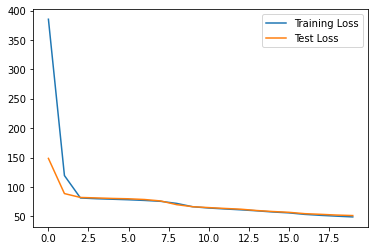

[21,     1] loss: 44.657
[21,     2] loss: 51.594
[21,     3] loss: 43.708
[21,     4] loss: 46.663
[21,     5] loss: 46.368
[21,     6] loss: 45.942
[21,     7] loss: 43.712
[21,     8] loss: 49.248
[21,     9] loss: 49.239
[21,    10] loss: 53.840
[21,    11] loss: 43.794
[21,    12] loss: 52.147
[21,    13] loss: 47.070
[21,    14] loss: 47.833
[21,    15] loss: 49.692
[21,    16] loss: 44.989
[21,    17] loss: 46.482
[21,    18] loss: 45.844
[21,    19] loss: 47.538
[21,    20] loss: 41.491
[21,    21] loss: 48.252
[21,    22] loss: 53.463
[21,    23] loss: 42.355
[21,    24] loss: 43.781
[21,    25] loss: 47.610
[21,    26] loss: 43.569
[21,    27] loss: 53.307
[21,    28] loss: 47.757
[21,    29] loss: 49.529
[21,    30] loss: 48.824
[21,    31] loss: 48.330
[21,    32] loss: 45.661
[21,    33] loss: 45.889
[21,    34] loss: 46.599
[21,    35] loss: 45.524
[21,    36] loss: 44.152
[21,    37] loss: 48.619
[21,    38] loss: 48.459
[21,    39] loss: 46.732
[21,    40] loss: 44.933


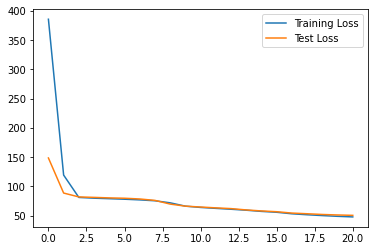

[22,     1] loss: 43.913
[22,     2] loss: 50.594
[22,     3] loss: 42.659
[22,     4] loss: 46.102
[22,     5] loss: 45.410
[22,     6] loss: 45.172
[22,     7] loss: 42.902
[22,     8] loss: 48.290
[22,     9] loss: 48.252
[22,    10] loss: 52.732
[22,    11] loss: 42.964
[22,    12] loss: 50.959
[22,    13] loss: 45.841
[22,    14] loss: 46.884
[22,    15] loss: 48.602
[22,    16] loss: 44.342
[22,    17] loss: 45.507
[22,    18] loss: 44.856
[22,    19] loss: 46.535
[22,    20] loss: 40.801
[22,    21] loss: 47.104
[22,    22] loss: 52.222
[22,    23] loss: 41.594
[22,    24] loss: 42.664
[22,    25] loss: 46.547
[22,    26] loss: 42.803
[22,    27] loss: 51.919
[22,    28] loss: 46.549
[22,    29] loss: 48.349
[22,    30] loss: 47.081
[22,    31] loss: 47.355
[22,    32] loss: 44.442
[22,    33] loss: 44.631
[22,    34] loss: 45.662
[22,    35] loss: 44.320
[22,    36] loss: 43.305
[22,    37] loss: 47.373
[22,    38] loss: 47.441
[22,    39] loss: 45.616
[22,    40] loss: 44.040


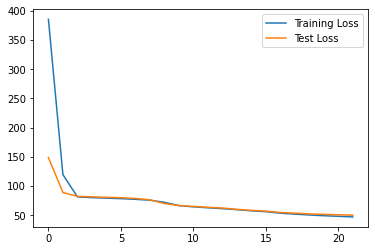

[23,     1] loss: 43.130
[23,     2] loss: 49.326
[23,     3] loss: 41.812
[23,     4] loss: 45.239
[23,     5] loss: 44.467
[23,     6] loss: 44.262
[23,     7] loss: 41.981
[23,     8] loss: 47.104
[23,     9] loss: 46.955
[23,    10] loss: 51.672
[23,    11] loss: 42.050
[23,    12] loss: 49.856
[23,    13] loss: 44.772
[23,    14] loss: 45.973
[23,    15] loss: 47.580
[23,    16] loss: 43.412
[23,    17] loss: 44.414
[23,    18] loss: 43.821
[23,    19] loss: 45.608
[23,    20] loss: 40.034
[23,    21] loss: 46.145
[23,    22] loss: 51.219
[23,    23] loss: 40.994
[23,    24] loss: 41.919
[23,    25] loss: 46.202
[23,    26] loss: 42.153
[23,    27] loss: 51.351
[23,    28] loss: 45.812
[23,    29] loss: 47.549
[23,    30] loss: 46.737
[23,    31] loss: 46.476
[23,    32] loss: 43.936
[23,    33] loss: 43.991
[23,    34] loss: 44.803
[23,    35] loss: 43.688
[23,    36] loss: 42.458
[23,    37] loss: 46.492
[23,    38] loss: 46.327
[23,    39] loss: 44.711
[23,    40] loss: 43.350


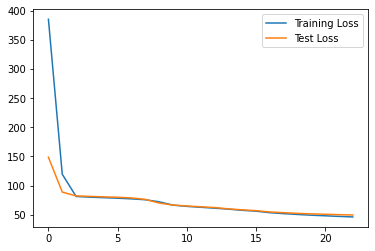

[24,     1] loss: 42.542
[24,     2] loss: 48.371
[24,     3] loss: 41.002
[24,     4] loss: 44.930
[24,     5] loss: 43.702
[24,     6] loss: 43.799
[24,     7] loss: 41.165
[24,     8] loss: 46.196
[24,     9] loss: 46.107
[24,    10] loss: 50.565
[24,    11] loss: 41.416
[24,    12] loss: 48.845
[24,    13] loss: 43.797
[24,    14] loss: 45.158
[24,    15] loss: 46.666
[24,    16] loss: 42.642
[24,    17] loss: 43.585
[24,    18] loss: 43.272
[24,    19] loss: 44.890
[24,    20] loss: 39.421
[24,    21] loss: 45.356
[24,    22] loss: 50.347
[24,    23] loss: 40.522
[24,    24] loss: 41.035
[24,    25] loss: 45.468
[24,    26] loss: 41.803
[24,    27] loss: 49.899
[24,    28] loss: 45.216
[24,    29] loss: 47.140
[24,    30] loss: 45.224
[24,    31] loss: 45.598
[24,    32] loss: 42.936
[24,    33] loss: 43.160
[24,    34] loss: 44.004
[24,    35] loss: 42.691
[24,    36] loss: 41.771
[24,    37] loss: 45.713
[24,    38] loss: 45.519
[24,    39] loss: 43.705
[24,    40] loss: 42.597


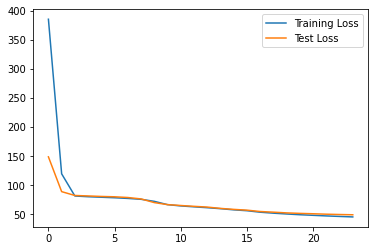

[25,     1] loss: 42.014
[25,     2] loss: 47.276
[25,     3] loss: 40.362
[25,     4] loss: 44.185
[25,     5] loss: 42.527
[25,     6] loss: 42.890
[25,     7] loss: 40.205
[25,     8] loss: 45.333
[25,     9] loss: 45.329
[25,    10] loss: 49.676
[25,    11] loss: 40.867
[25,    12] loss: 47.881
[25,    13] loss: 42.979
[25,    14] loss: 44.321
[25,    15] loss: 45.885
[25,    16] loss: 41.896
[25,    17] loss: 42.773
[25,    18] loss: 42.704
[25,    19] loss: 44.183
[25,    20] loss: 38.773
[25,    21] loss: 44.628
[25,    22] loss: 49.297
[25,    23] loss: 39.568
[25,    24] loss: 40.362
[25,    25] loss: 44.596
[25,    26] loss: 40.939
[25,    27] loss: 48.976
[25,    28] loss: 44.600
[25,    29] loss: 46.203
[25,    30] loss: 44.124
[25,    31] loss: 44.808
[25,    32] loss: 42.445
[25,    33] loss: 42.342
[25,    34] loss: 43.334
[25,    35] loss: 42.121
[25,    36] loss: 41.147
[25,    37] loss: 45.048
[25,    38] loss: 44.381
[25,    39] loss: 43.054
[25,    40] loss: 41.825


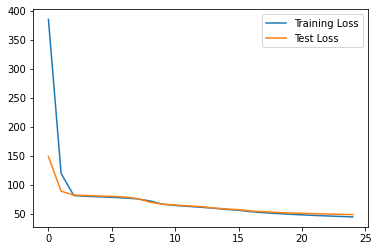

[26,     1] loss: 41.386
[26,     2] loss: 46.135
[26,     3] loss: 39.552
[26,     4] loss: 42.748
[26,     5] loss: 41.776
[26,     6] loss: 42.293
[26,     7] loss: 39.222
[26,     8] loss: 44.613
[26,     9] loss: 44.344
[26,    10] loss: 48.974
[26,    11] loss: 40.126
[26,    12] loss: 46.996
[26,    13] loss: 42.262
[26,    14] loss: 43.581
[26,    15] loss: 45.291
[26,    16] loss: 41.175
[26,    17] loss: 42.419
[26,    18] loss: 41.940
[26,    19] loss: 43.390
[26,    20] loss: 38.176
[26,    21] loss: 44.160
[26,    22] loss: 48.146
[26,    23] loss: 38.616
[26,    24] loss: 39.740
[26,    25] loss: 43.361
[26,    26] loss: 40.205
[26,    27] loss: 48.089
[26,    28] loss: 43.351
[26,    29] loss: 44.726
[26,    30] loss: 43.350
[26,    31] loss: 43.960
[26,    32] loss: 41.473
[26,    33] loss: 41.360
[26,    34] loss: 42.830
[26,    35] loss: 41.450
[26,    36] loss: 40.217
[26,    37] loss: 43.982
[26,    38] loss: 43.708
[26,    39] loss: 42.182
[26,    40] loss: 40.908


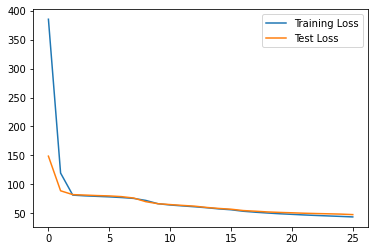

[27,     1] loss: 40.486
[27,     2] loss: 45.015
[27,     3] loss: 38.683
[27,     4] loss: 41.791
[27,     5] loss: 40.970
[27,     6] loss: 40.921
[27,     7] loss: 38.261
[27,     8] loss: 43.459
[27,     9] loss: 43.301
[27,    10] loss: 47.920
[27,    11] loss: 38.954
[27,    12] loss: 46.397
[27,    13] loss: 41.334
[27,    14] loss: 43.027
[27,    15] loss: 44.315
[27,    16] loss: 40.551
[27,    17] loss: 41.396
[27,    18] loss: 41.122
[27,    19] loss: 42.828
[27,    20] loss: 37.507
[27,    21] loss: 43.196
[27,    22] loss: 46.845
[27,    23] loss: 37.968
[27,    24] loss: 38.921
[27,    25] loss: 42.735
[27,    26] loss: 39.431
[27,    27] loss: 47.128
[27,    28] loss: 42.412
[27,    29] loss: 43.936
[27,    30] loss: 42.471
[27,    31] loss: 42.813
[27,    32] loss: 40.736
[27,    33] loss: 40.349
[27,    34] loss: 41.894
[27,    35] loss: 40.552
[27,    36] loss: 39.416
[27,    37] loss: 42.990
[27,    38] loss: 42.567
[27,    39] loss: 41.255
[27,    40] loss: 40.113


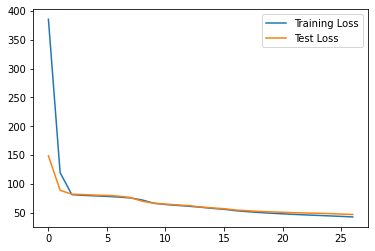

[28,     1] loss: 39.727
[28,     2] loss: 44.084
[28,     3] loss: 38.068
[28,     4] loss: 41.082
[28,     5] loss: 40.205
[28,     6] loss: 40.268
[28,     7] loss: 37.526
[28,     8] loss: 42.542
[28,     9] loss: 42.411
[28,    10] loss: 46.792
[28,    11] loss: 38.264
[28,    12] loss: 45.157
[28,    13] loss: 40.500
[28,    14] loss: 42.026
[28,    15] loss: 43.488
[28,    16] loss: 39.623
[28,    17] loss: 40.171
[28,    18] loss: 40.102
[28,    19] loss: 41.812
[28,    20] loss: 36.851
[28,    21] loss: 42.238
[28,    22] loss: 45.792
[28,    23] loss: 37.197
[28,    24] loss: 38.116
[28,    25] loss: 41.884
[28,    26] loss: 38.669
[28,    27] loss: 46.098
[28,    28] loss: 41.296
[28,    29] loss: 43.266
[28,    30] loss: 41.508
[28,    31] loss: 41.911
[28,    32] loss: 39.914
[28,    33] loss: 39.610
[28,    34] loss: 41.013
[28,    35] loss: 39.598
[28,    36] loss: 38.551
[28,    37] loss: 42.043
[28,    38] loss: 41.633
[28,    39] loss: 40.363
[28,    40] loss: 39.513


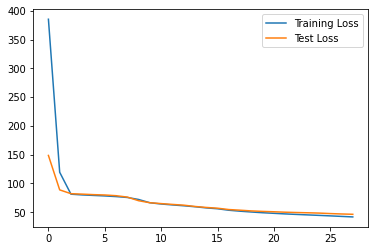

[29,     1] loss: 39.116
[29,     2] loss: 42.990
[29,     3] loss: 37.352
[29,     4] loss: 40.711
[29,     5] loss: 39.818
[29,     6] loss: 39.764
[29,     7] loss: 37.014
[29,     8] loss: 41.983
[29,     9] loss: 42.150
[29,    10] loss: 46.878
[29,    11] loss: 38.678
[29,    12] loss: 45.109
[29,    13] loss: 40.376
[29,    14] loss: 41.402
[29,    15] loss: 43.233
[29,    16] loss: 39.085
[29,    17] loss: 39.588
[29,    18] loss: 39.803
[29,    19] loss: 41.109
[29,    20] loss: 36.465
[29,    21] loss: 41.788
[29,    22] loss: 45.617
[29,    23] loss: 36.844
[29,    24] loss: 37.805
[29,    25] loss: 42.008
[29,    26] loss: 38.434
[29,    27] loss: 45.811
[29,    28] loss: 41.334
[29,    29] loss: 43.299
[29,    30] loss: 41.372
[29,    31] loss: 41.203
[29,    32] loss: 40.006
[29,    33] loss: 39.116
[29,    34] loss: 41.265
[29,    35] loss: 39.144
[29,    36] loss: 38.848
[29,    37] loss: 42.054
[29,    38] loss: 41.153
[29,    39] loss: 40.214
[29,    40] loss: 38.966


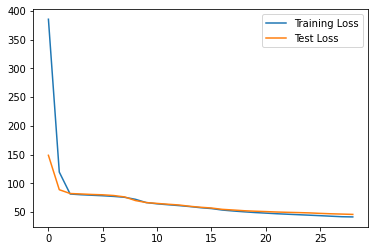

[30,     1] loss: 38.422
[30,     2] loss: 42.454
[30,     3] loss: 36.620
[30,     4] loss: 40.045
[30,     5] loss: 39.237
[30,     6] loss: 39.078
[30,     7] loss: 36.668
[30,     8] loss: 40.966
[30,     9] loss: 41.555
[30,    10] loss: 45.029
[30,    11] loss: 37.575
[30,    12] loss: 43.779
[30,    13] loss: 39.872
[30,    14] loss: 41.529
[30,    15] loss: 42.042
[30,    16] loss: 38.748
[30,    17] loss: 38.957
[30,    18] loss: 39.081
[30,    19] loss: 40.677
[30,    20] loss: 35.787
[30,    21] loss: 41.280
[30,    22] loss: 44.031
[30,    23] loss: 36.624
[30,    24] loss: 37.330
[30,    25] loss: 41.326
[30,    26] loss: 37.742
[30,    27] loss: 46.123
[30,    28] loss: 39.849
[30,    29] loss: 42.478
[30,    30] loss: 41.274
[30,    31] loss: 41.363
[30,    32] loss: 39.286
[30,    33] loss: 40.138
[30,    34] loss: 41.905
[30,    35] loss: 38.757
[30,    36] loss: 37.444
[30,    37] loss: 42.642
[30,    38] loss: 42.378
[30,    39] loss: 39.108
[30,    40] loss: 39.441


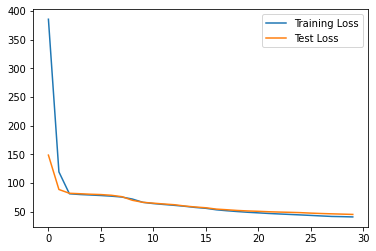

Finished Training


In [ ]:
train_loss_graph = []
test_loss_graph = []

indian_loss_graph = []
western_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
      
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)

print('Finished Training')

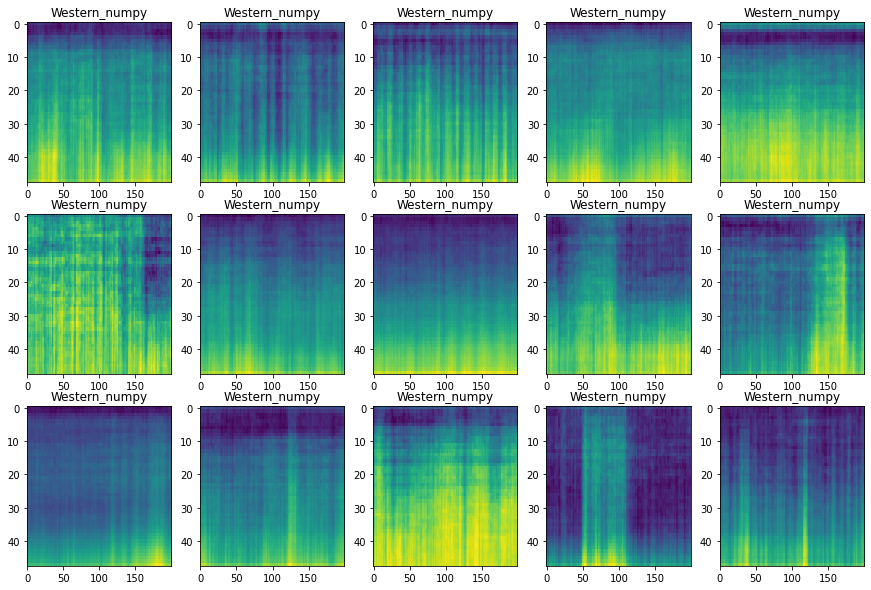

In [ ]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

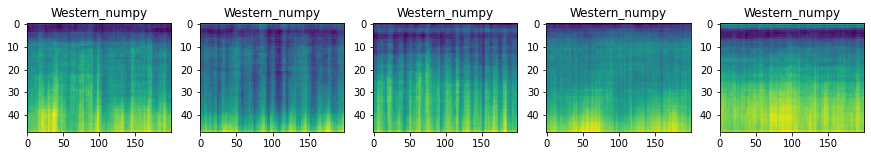

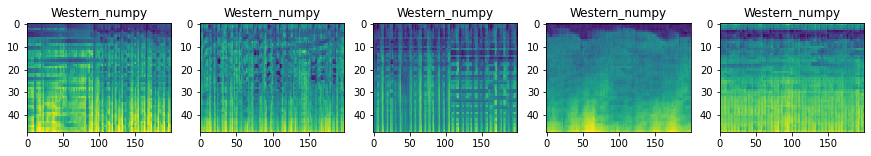

In [ ]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [ ]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [ ]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Strict data separation

In [ ]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    #print("removing ", os.path.join(dir, f))
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


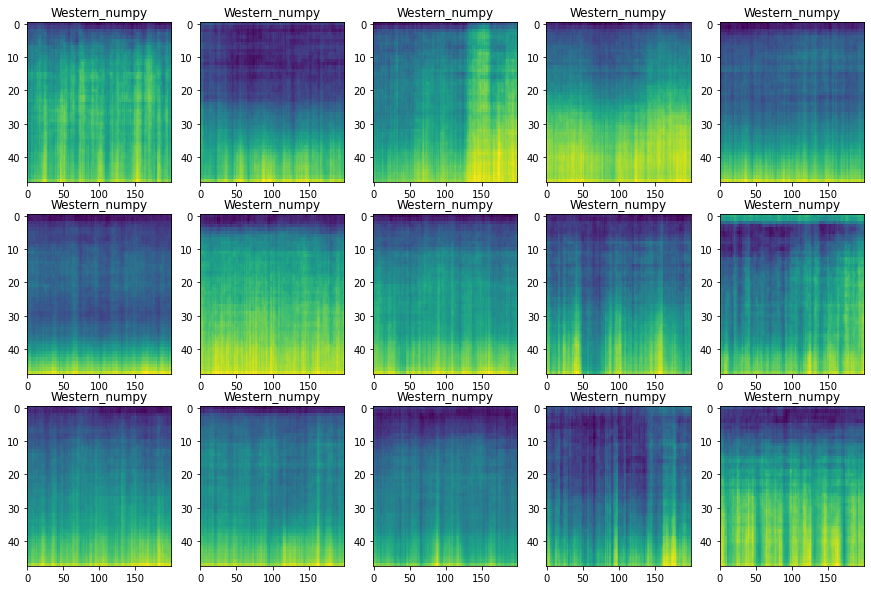

In [ ]:
# get some random training images
dataiter = iter(trainloader_combined)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

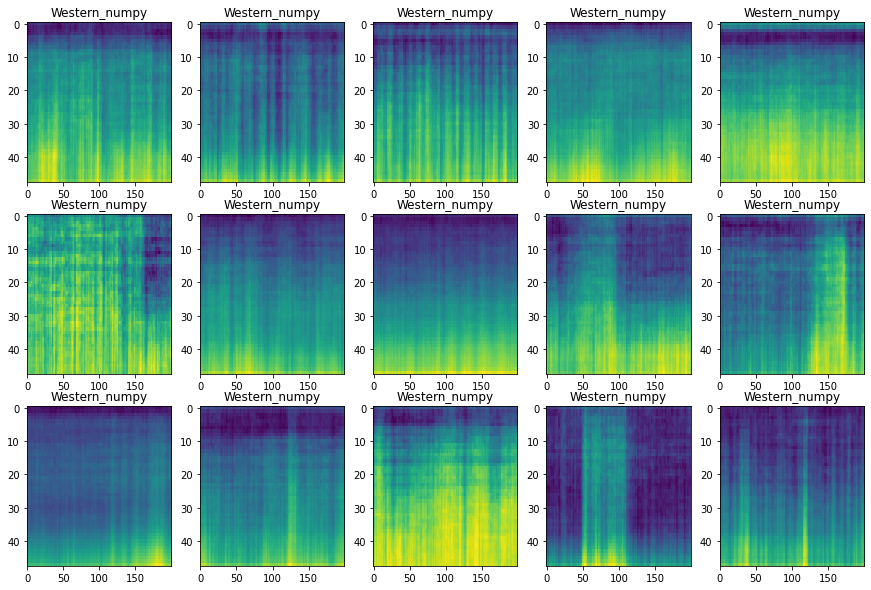

In [ ]:
# get some random training images
dataiter = iter(testloader_combined)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
id_test = 0
with torch.no_grad():
    for data_test in testloader_combined:
        inputs, labels, fileNames = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/test/Western_numpy/western_130993_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/test/Western_numpy/western_120189_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/test/Western_numpy/western_111579_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/test/Western_numpy/western_111793_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/test/Western_numpy/western_122503_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/test/Western_numpy/western_075975_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/test/Western_numpy/western_129695_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/test/Western_numpy/western_086443_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/test/Western_numpy/western_129042_mel_1.npy
/content/gdrive/My Drive/vaj

In [ ]:
id_train = 0
with torch.no_grad():
    for data in trainloader_combined:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_train = id_train + 1

Streaming output truncated to the last 5000 lines.
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/training/Western_numpy/western_134931_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/training/Western_numpy/western_039900_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/training/Western_numpy/western_038353_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/training/Western_numpy/western_093917_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/training/Western_numpy/western_140609_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/training/Western_numpy/western_003598_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/training/Western_numpy/western_140260_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Activations_64/training/Western_numpy/western_066636_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_WESTERN/Acti